In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import os

## 01 - Data preprocessing and merging
# 1. Load the raw CSVs from Olist dataset
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')

# 2. Merge all the tables step by step using 'left' joins
# This ensures we keep all rows from the orders table
# Merge datasets
df = orders.merge(customers, on='customer_id', how='left')
# Merge datasets
df = df.merge(order_items, on='order_id', how='left')
# Merge datasets
df = df.merge(products, on='product_id', how='left')
# Merge datasets
df = df.merge(sellers, on='seller_id', how='left')

print(df.head())
print(df.describe())

# 3. Check and print missing values
missing = df.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print("⚠️ Missing values detected:")
    print(missing)
else:
    print("✅ No missing values detected.")

# ✅ Always calculate and display percentages if any missing values exist
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

if not missing_percent.empty:
    print("\n📊 Missing Value Percentages:")
    print(missing_percent)

# 4. Check and remove duplicate rows
# Check and remove duplicate rows
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"⚠️ Found {duplicates} duplicate rows. Dropping them...")
    df = df.drop_duplicates()
else:
    print("✅ No duplicate rows found.")

# 5. Convert date columns to datetime format (with error handling)
# Convert columns to datetime format
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce')
# Convert columns to datetime format
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'], errors='coerce')
# Convert columns to datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')

# 6. Drop rows with missing values in essential columns
required_columns = [
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_purchase_timestamp',
    'product_weight_g',
    'product_category_name',
    'customer_state'
]
# Drop rows with missing values in required columns
df = df.dropna(subset=required_columns)

# 7. Keep only rows where order was delivered
df = df[df['order_status'] == 'delivered']


# 8. Feature engineering
# Create 'shipping_days' = estimated delivery time in days
# Calculate shipping days (estimated - purchase date)
df['shipping_days'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

# Create 'shipping_days_dif' = estimated dif between Delivery and Estimated
df['shipping_days_dif'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['abs_shipping_days_dif'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days.abs()


# Create binary target 'delay' = 1 if delivered late, else 0
# Create delay target column (1 = late, 0 = on time)
df['delay'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)

# Mapping for customer_state
customer_state_mapping = dict(enumerate(df['customer_state'].astype('category').cat.categories))

# Mapping for product_category_name
product_category_mapping = dict(enumerate(df['product_category_name'].astype('category').cat.categories))

# Optional: Print them nicely
print("Customer State Mapping:")
print(customer_state_mapping)

print("\nProduct Category Mapping:")
print(product_category_mapping)

# 9. Encode categorical variables
# Encode categorical column to numeric values
df['customer_state_encoded'] = df['customer_state'].astype('category').cat.codes
# Encode categorical column to numeric values
df['product_category_encoded'] = df['product_category_name'].astype('category').cat.codes
# ✅ NEW: Encode seller's state
df['seller_state_encoded'] = df['seller_state'].astype('category').cat.codes

# 10. Select final columns for modeling (including seller state now)
final_df = df[[
    'order_id',
    'shipping_days',
    'delay',
    'product_weight_g',
    'customer_state_encoded',
    'product_category_encoded',
    'seller_state_encoded'
]]

# 11. Export cleaned dataset to CSV
final_df.to_csv('Olist_Simplified_Cleaned_Dataset.csv', index=False)
print("✅ Final dataset saved as 'Olist_Simplified_Cleaned_Dataset.csv'")

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered         2017-10-02 10:56  2017-10-02 11:07   
1    delivered         2018-07-24 20:41   2018-07-26 3:24   
2    delivered          2018-08-08 8:38   2018-08-08 8:55   
3    delivered         2017-11-18 19:28  2017-11-18 19:45   
4    delivered         2018-02-13 21:18  2018-02-13 22:20   

  order_delivered_carrier_date order_delivered_customer_date  \
0             2017-10-04 19:55              2017-10-10 21:25   
1             2018-07-26 14:31              2018-08-07 15:27   
2 

In [23]:
# Minimum and maximum value of shipping_days'

print(df['shipping_days'].min())
print(df['shipping_days'].max())

2
155


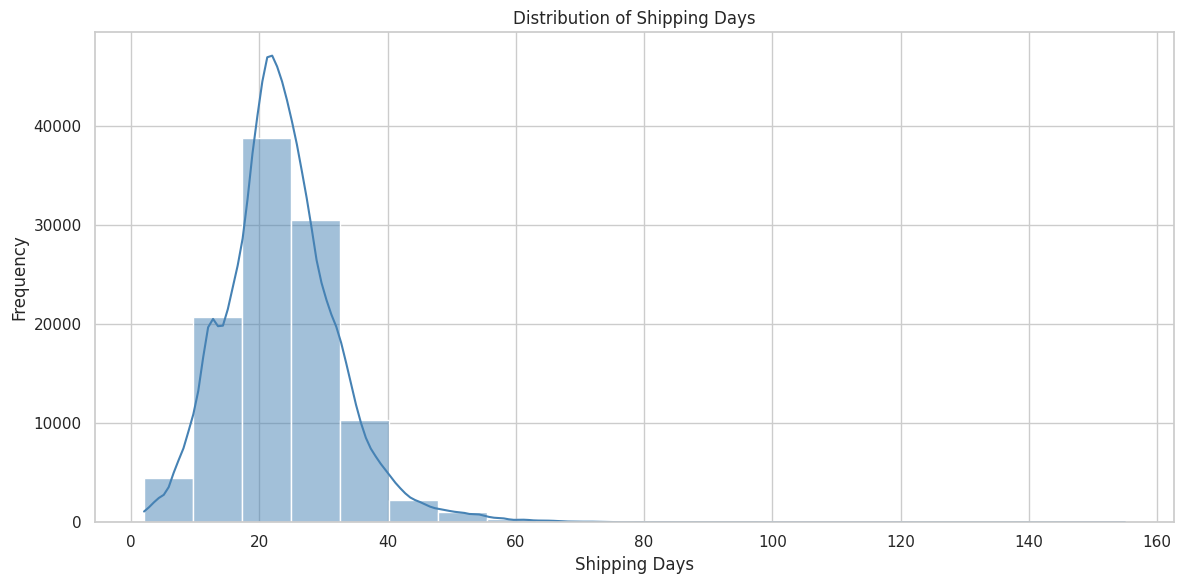

<ipython-input-24-eda7cafac959>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_delay.index.astype(str), y=category_delay.values, palette=palette)


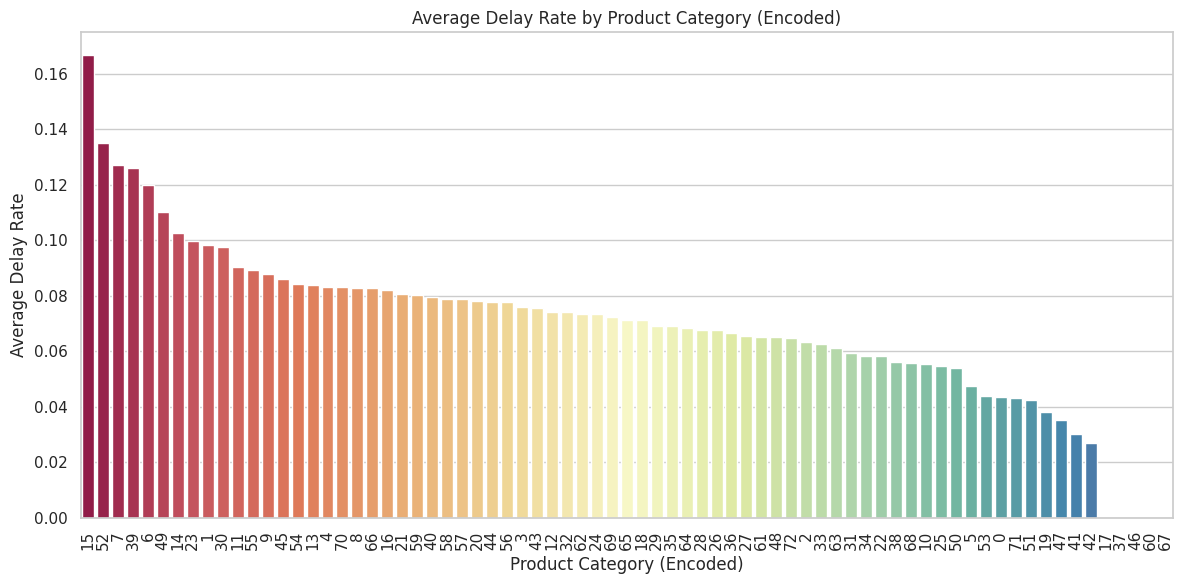

<ipython-input-24-eda7cafac959>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_delay.index.astype(str), y=state_delay.values, palette=palette)


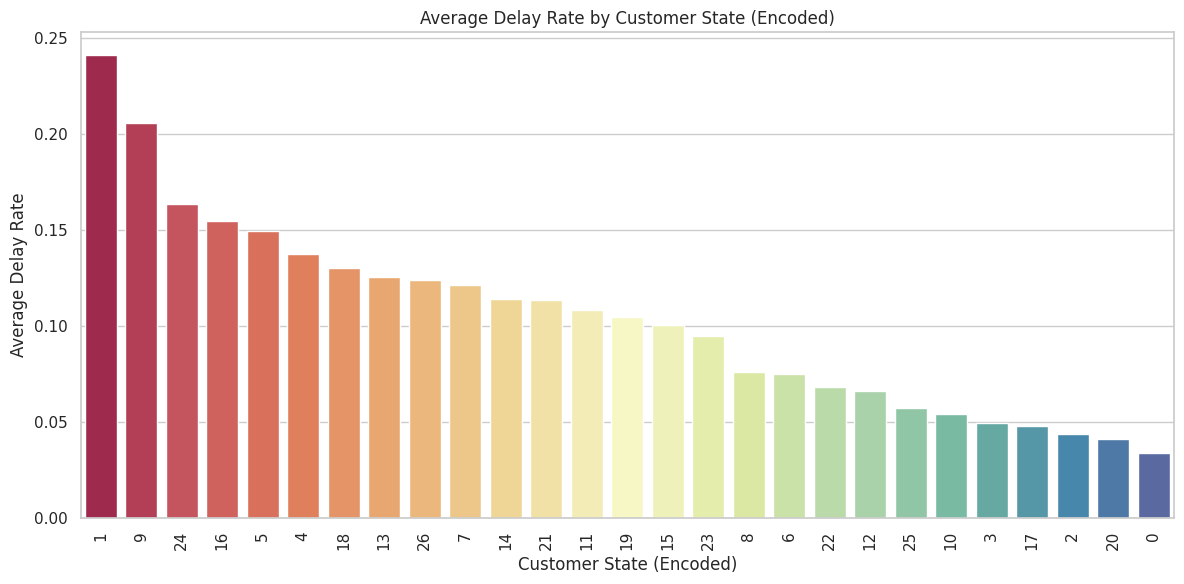

<ipython-input-24-eda7cafac959>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='delay', y='shipping_days', data=filtered_df, palette='Set2')


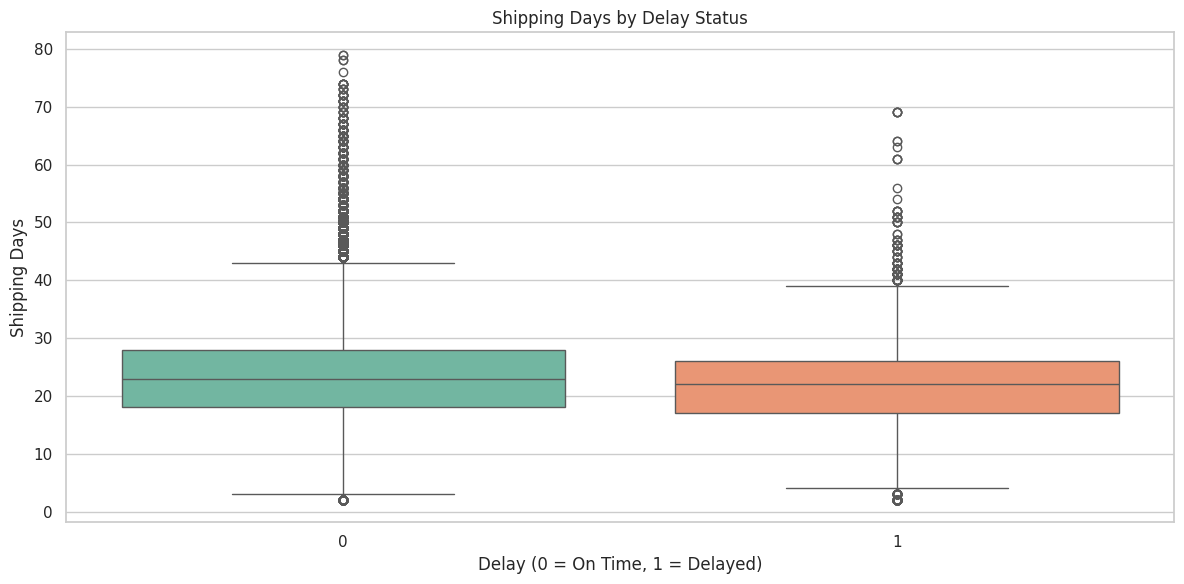

<ipython-input-24-eda7cafac959>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='delay', y='abs_shipping_days_dif', data=filtered_df, palette='Set2')


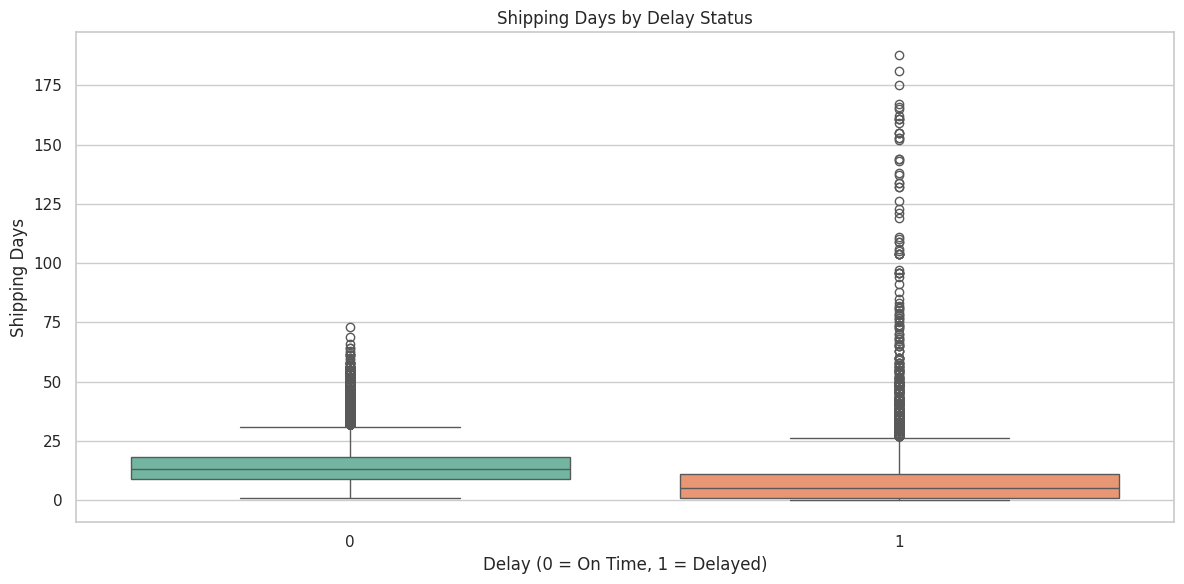

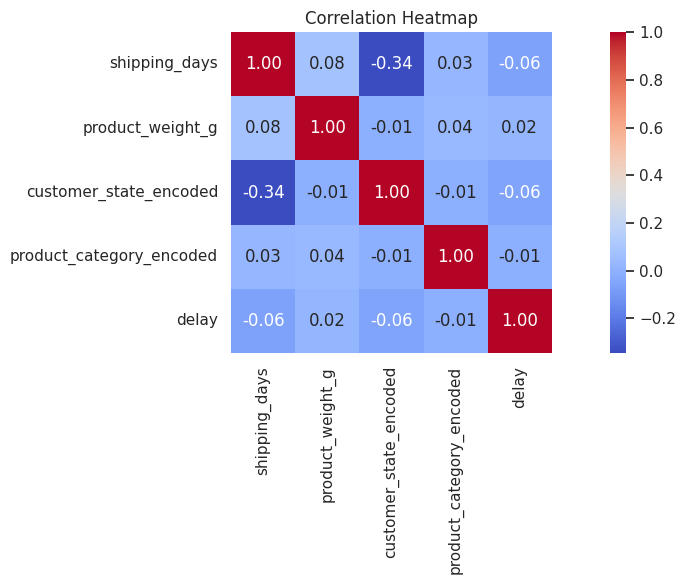

In [24]:
# 02 - EDA: Olist Shipping Delay Project
# This Section Exploratory Data Analysis (EDA) on the cleaned Olist dataset.

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
#os.makedirs('eda_outputs', exist_ok=True)


# 1. Histogram: Shipping Days Distribution
plt.figure()
sns.histplot(df['shipping_days'], bins=20, kde=True, color='steelblue')
plt.title('Distribution of Shipping Days')
plt.xlabel('Shipping Days')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2. Bar Plot: Delay Rate by Product Category (Encoded) with Color Gradient
plt.figure()
category_delay = df.groupby('product_category_encoded')['delay'].mean().sort_values(ascending=False)
palette = sns.color_palette("Spectral", n_colors=len(category_delay))
# Barplot of average delay rate by category/state
sns.barplot(x=category_delay.index.astype(str), y=category_delay.values, palette=palette)
plt.title('Average Delay Rate by Product Category (Encoded)')
plt.xlabel('Product Category (Encoded)')
plt.ylabel('Average Delay Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Bar Plot: Delay Rate by Customer State (Encoded) with Color Gradient
plt.figure()
state_delay = df.groupby('customer_state_encoded')['delay'].mean().sort_values(ascending=False)
palette = sns.color_palette("Spectral", n_colors=len(state_delay))
# Barplot of average delay rate by category/state
sns.barplot(x=state_delay.index.astype(str), y=state_delay.values, palette=palette)
plt.title('Average Delay Rate by Customer State (Encoded)')
plt.xlabel('Customer State (Encoded)')
plt.ylabel('Average Delay Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# 4. Boxplot: Shipping Days by Delay Status with color
plt.figure()
filtered_df = df[df['shipping_days'] < 80]
# Boxplot to compare delay status with numerical variable
sns.boxplot(x='delay', y='abs_shipping_days_dif', data=filtered_df, palette='Set2')
plt.title('Absolute Difference in Shipping Days (Delay Analysis)')
plt.xlabel('Delay (0 = On Time, 1 = Delayed)')
plt.ylabel('Shipping Days')
plt.tight_layout()
plt.show()

# 5. Correlation Heatmap
plt.figure()
corr = df[['shipping_days', 'product_weight_g', 'customer_state_encoded', 'product_category_encoded', 'delay']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Percentage of value 0 (On time): 92.11235975738833%
Percentage of value 1 (Delay): 7.887640242611665%


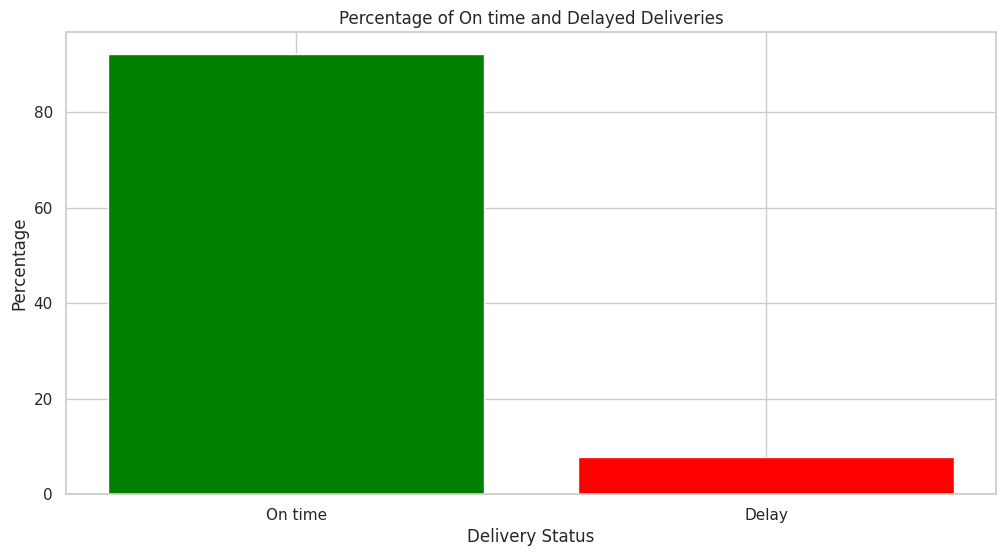

In [25]:

# Check class distribution
percentage_0 = (df['delay'].value_counts(normalize=True) * 100)[0]
percentage_1 = (df['delay'].value_counts(normalize=True) * 100)[1]

print(f"Percentage of value 0 (On time): {percentage_0}%")
print(f"Percentage of value 1 (Delay): {percentage_1}%")

# Define labels and values for bar plot
labels = ['On time', 'Delay']
percentages = [percentage_0, percentage_1]
colors = ['green', 'red']

# Plot the class distribution
plt.bar(labels, percentages, color=colors)
plt.xlabel('Delivery Status')
plt.ylabel('Percentage')
plt.title('Percentage of On time and Delayed Deliveries')
plt.show()




🔍 Individual Model Reports (Before Balancing):

Logistic Regression Classification Report (Before Balancing):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     20013
           1       0.00      0.00      0.00      1718

    accuracy                           0.92     21731
   macro avg       0.46      0.50      0.48     21731
weighted avg       0.85      0.92      0.88     21731



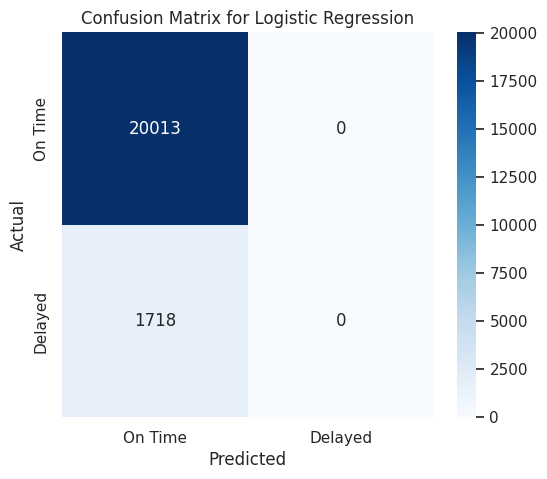


Decision Tree Classification Report (Before Balancing):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     20013
           1       0.26      0.24      0.25      1718

    accuracy                           0.89     21731
   macro avg       0.60      0.59      0.59     21731
weighted avg       0.88      0.89      0.88     21731



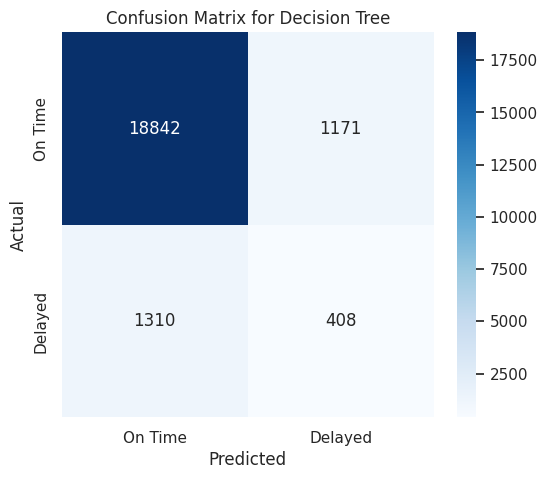


Random Forest Classification Report (Before Balancing):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     20013
           1       0.40      0.17      0.24      1718

    accuracy                           0.91     21731
   macro avg       0.67      0.57      0.60     21731
weighted avg       0.89      0.91      0.90     21731



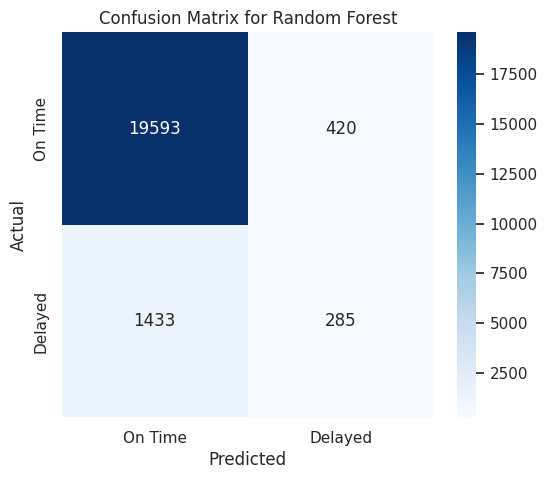


🔍 Individual Model Reports (After Balancing):

Logistic Regression Classification Report (After Balancing):
              precision    recall  f1-score   support

           0       0.94      0.54      0.69     20013
           1       0.10      0.60      0.17      1718

    accuracy                           0.55     21731
   macro avg       0.52      0.57      0.43     21731
weighted avg       0.87      0.55      0.65     21731



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


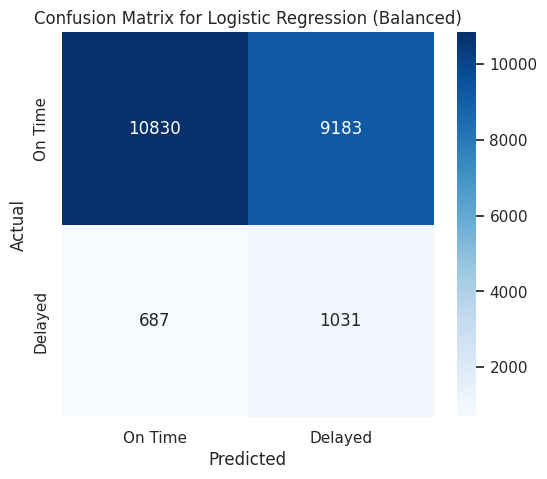


Decision Tree Classification Report (After Balancing):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     20013
           1       0.20      0.29      0.23      1718

    accuracy                           0.85     21731
   macro avg       0.57      0.59      0.58     21731
weighted avg       0.88      0.85      0.86     21731



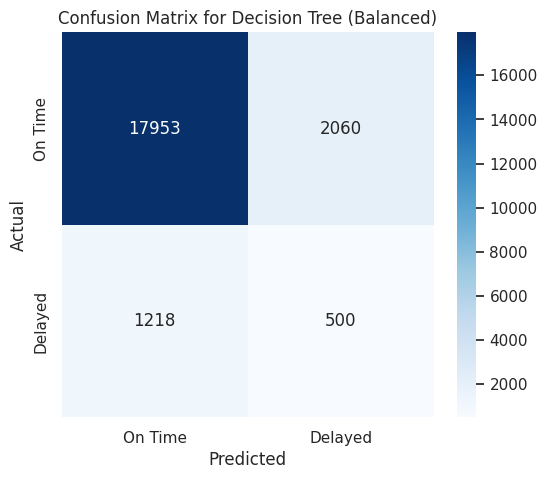


Random Forest Classification Report (After Balancing):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     20013
           1       0.26      0.21      0.23      1718

    accuracy                           0.89     21731
   macro avg       0.60      0.58      0.59     21731
weighted avg       0.88      0.89      0.89     21731



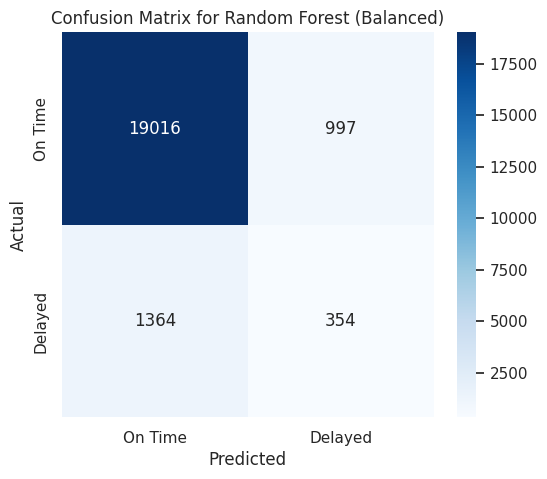

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



✅ Voting Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     20013
           1       0.22      0.26      0.24      1718

    accuracy                           0.87     21731
   macro avg       0.58      0.59      0.58     21731
weighted avg       0.88      0.87      0.87     21731



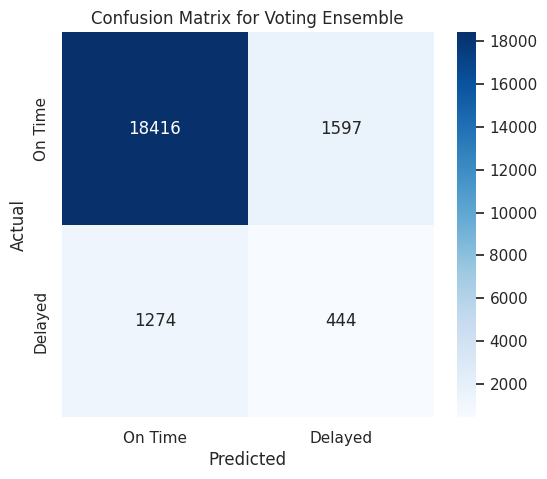

<ipython-input-28-fd3fd930f144>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Set2')


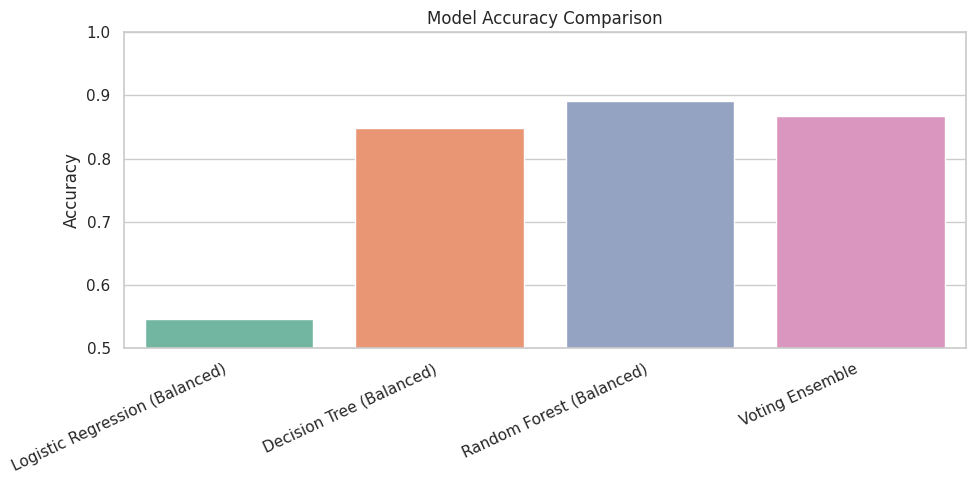

💾 Saved Logistic Regression model as 'logistic_regression_model.pkl'
💾 Saved Decision Tree model as 'decision_tree_model.pkl'
💾 Saved Random Forest model as 'random_forest_model.pkl'
💾 Saved Voting Ensemble model as 'voting_ensemble_model.pkl'


In [28]:
# 03 - Model Training with Ensemble and Balanced Classes

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# ----------------------------------------
# Define features and target variable (✅ seller_state_encoded included)
X = df[['shipping_days', 'product_weight_g', 'customer_state_encoded', 'product_category_encoded', 'seller_state_encoded']]
y = df['delay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# ----------------------------------------

# Define base models
log_reg = LogisticRegression()
dec_tree = DecisionTreeClassifier()
rand_forest = RandomForestClassifier()

# Group them into a dictionary
models = {
    'Logistic Regression': log_reg,
    'Decision Tree': dec_tree,
    'Random Forest': rand_forest
}

results = {}  # Store accuracy of all models

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Train and evaluate each individual model without balancing (optional analysis)
print("\n🔍 Individual Model Reports (Before Balancing):")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report (Before Balancing):")
    print(classification_report(y_test, y_pred, zero_division=0))
    plot_confusion_matrix(y_test, y_pred, name)

# Train and evaluate each individual model with balancing
print("\n🔍 Individual Model Reports (After Balancing):")
for name, model in models.items():
    if isinstance(model, (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier)):
        model = model.__class__(class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report (After Balancing):")
    print(classification_report(y_test, y_pred, zero_division=0))
    plot_confusion_matrix(y_test, y_pred, f"{name} (Balanced)")

    # ✅ Add accuracy to results for final comparison chart
    results[name + " (Balanced)"] = model.score(X_test, y_test)

# Create and evaluate VotingClassifier ensemble
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(class_weight='balanced')),
    ('dt', DecisionTreeClassifier(class_weight='balanced')),
    ('rf', RandomForestClassifier(class_weight='balanced'))
], voting='hard')

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_report = classification_report(y_test, y_pred_ensemble, output_dict=True, zero_division=0)
results['Voting Ensemble'] = ensemble_report['accuracy']

print("\n✅ Voting Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble, zero_division=0))
plot_confusion_matrix(y_test, y_pred_ensemble, "Voting Ensemble")

# Compare model accuracy visually
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Set2')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=25, ha='right')  # ✅ Rotación de texto
plt.tight_layout()
plt.show()


# Save all models
joblib.dump(log_reg, 'logistic_regression_model.pkl')
print("💾 Saved Logistic Regression model as 'logistic_regression_model.pkl'")

joblib.dump(dec_tree, 'decision_tree_model.pkl')
print("💾 Saved Decision Tree model as 'decision_tree_model.pkl'")

joblib.dump(rand_forest, 'random_forest_model.pkl')
print("💾 Saved Random Forest model as 'random_forest_model.pkl'")

joblib.dump(ensemble_model, 'voting_ensemble_model.pkl')
print("💾 Saved Voting Ensemble model as 'voting_ensemble_model.pkl'")
